# FORESEE - ALP with photon couplings

### Load Libraries 

In [1]:
import numpy as np
import sys
import os
src_path = "/Users/felixkling/Documents/GitHub/FORESEE"
sys.path.append(src_path)
from src.foresee import Foresee, Utility, Model

## 1. Initialization 

All function that we will need are included in the FORESEE package. We start by simply initializing it: 

In [2]:
foresee = Foresee()

The ALP is mainly produced via the Primakoff process (so photon to ALP conversion in material). To start, let us have a look at the photon spectrum in terms of the angle with respect to the beam axis $\theta$ and the momentum $p$. This can be done using the function `get_spectrumplot` which requires the MC particle ID (or simply pid), the MC generator and the energy. The units on the coloraxis are pb/bin. 

FORESEE provides the 2D spectrum as tables for a variety of particles ($\pi^0$, $\eta$, ...), generators (SIBYLL, EPOSLHC, QGSJET, PYTHIA) and collision energies (14, 27 and 100 TeV). The datafiles are stored in the directory `files/hadrons`. 

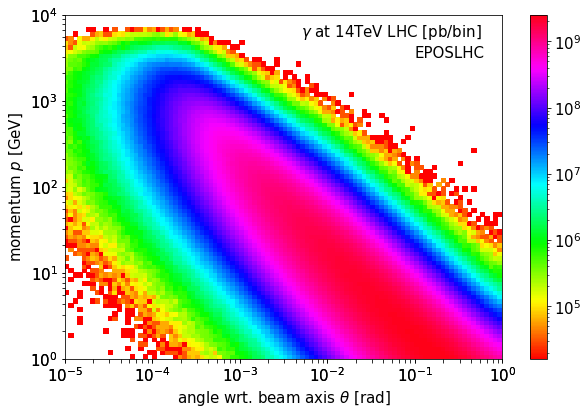

In [3]:
plot=foresee.get_spectrumplot(pid="22", generator="EPOSLHC", energy="14", prange=[[-5, 0, 100],[ 0, 4, 80]])
plot.text(-2.3,3.75, r"$\gamma$ at 14TeV LHC [pb/bin]",fontsize=15,color="k",rotation=0)
plot.text(-1,3.5, r"EPOSLHC",fontsize=15,color="k",rotation=0)
plot.subplots_adjust(left=0.10, right=1.05, bottom=0.10, top=0.97)
plot.savefig("/Users/felixkling/Downloads/Figure.pdf")
plot.show()

## 2. Specifying the Model: ALP-Photon

The phenomenology of the ALP with $\gamma$-couplings can be described by the following Lagrangian

\begin{equation}
 \mathcal{L} = - \frac{1}{2} m_{a}^2 a^2  - \frac{g}{4}a F^a_{\mu\nu} \tilde F^a_{\mu\nu}
\end{equation}

with the ALP mass $a$ and the coupling parameter $g$ as free parameters. For the search for ALPS at forward experiments we need to know i) the *production rate*, ii) the *lifetime* and iii) possibly the *decay branching fractions* of dark photons as function of those two parameters. All properties are specified in the `Model` class. We initialize it with the name of the model as argument. 

In [4]:
energy = "14"
modelname = "ALP-photon"
model = Model(modelname)

**Production** The Dark Higgs is mainly produced via the Primakoff Process. Following [1806.02348](https://arxiv.org/pdf/1806.02348.pdf) Eq (6), the Primakoff cross section is given by
\begin{equation}
 \frac{d\sigma}{d\log\theta } 
 = \theta \frac{d\sigma}{d\log\theta} = g^2 \frac{\alpha Z^2}{4} \times F(t)^2 \times \frac{p_a^4 \theta^4}{t^2}
\end{equation}
where $p_a \approx E_\gamma$, $t = m_a^4 / (2E_\gamma^2) + E_\gamma^2 \theta^2$ and the form factor is given by $F(t) = a^2t/(1+a^2t)$ for $t<7.39m_e^2$ and $F(t) = 1/(1+t/d)$ for $t>7.39m_e^2$. 

We have obtained the ALP spectra and saved them as `model/direct`. See also the separate notebook contaning the code in the same folder. We now load the spectra via the `model.add_production_direct()` function. 

In [5]:
masses = [float(x) for x in ['{:0.4e}'.format(m) for m in np.logspace(-2,0,20+1)]]
model.add_production_direct(
    label = "Prim",
    energy = energy,
    coupling_ref=1,
    masses=masses,
)

Particles can also be produced directly in collisions or via mixing with SM particles. However, we will not use this in this example. 

**Lifetime:** For most models the lifetime can be written as $\ c\tau(m,g)\  =\  c\tau(m,g_*) \ \cdot\  g_*^2 \ / \ g^{2}$ where $m$ is the mass, $g$ is the coupling and $g_*$ is some reference coupling. In this case, we can provide a table of masses $m$ and lifetimes $c\tau(m,g_*)$ at a reference coupling $g_*$ using `model.set_ctau_1d`. Alternatively, one can also provide a table of masses $m$, couplings $g$ and lifetimes $c\tau(m,g)$ via `model.set_ctau_2d()`. 

In [6]:
model.set_ctau_1d(
    filename="model/ctau.txt", 
    coupling_ref=1
)

**Branching Fractions:** For most models, the branching fractions into particular decay channels are independent of the overall couplings. In this case, we can provide a set of tables of masses $m$ and branching fractions $BR(m)$ using `model.set_br_1d`. Alternatively, we can also provide table of masses $m$, couplings $g$ and brnaching fraction $BR(m,g)$ via `model.set_br_2d()`. In both cases, we need to specify a list of decay modes and a list of filenames with the corresponding data tables. 

In [7]:
branchings = [
    ["gamma"     , "black"        , "solid" , r"$\gamma\gamma$"         , 0.110, 0.50],
    ["eegamma"   , "red"          , "solid" , r"$ee\gamma$"             , 0.225, 0.03],
]

model.set_br_1d(
    modes=[channel for channel,_,_,_,_,_ in branchings],
    finalstates=[[22,22], [11,-11, 22]],
    filenames=["model/br/"+channel+".txt" for channel,_,_,_,_,_ in branchings],
)

## 3. Generate LLP Spectra

After we have specified the model, let us generate the LLP spectra. We first set the model we just created. 

In [8]:
foresee.set_model(model=model)

Let's first look at one benchmark scenario with $m_{a}=0.1$ GeV and $g=10^{-4}$ using the function `foresee.get_llp_spectrum()`. By default, the result are saved in the `model/LLP_spectra` directory. However, here set `save_file=False` since we don't want to save the results but set `do_plot=True` to plot them. 

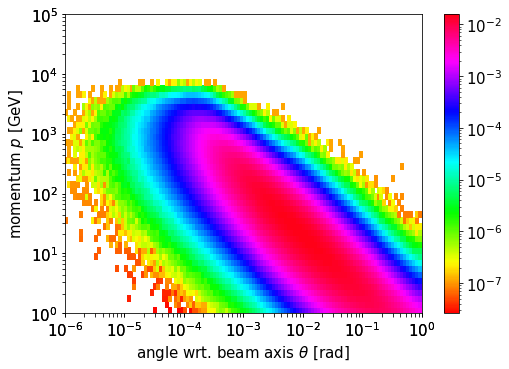

In [9]:
plt = foresee.get_llp_spectrum(mass=0.1, coupling=1e-4, do_plot=True, save_file=False)
plt.show()

We can now produce a set of LLP spectra for various masses and unit coupling and save them.  

In [10]:
masses = np.logspace(-2,0,40+1)

for mass in masses:
    foresee.get_llp_spectrum(mass=mass,coupling=1)

save data to file: model/LLP_spectra/14TeV_Prim_m_0.01.npy
save data to file: model/LLP_spectra/14TeV_Prim_m_0.011220184543019636.npy
save data to file: model/LLP_spectra/14TeV_Prim_m_0.012589254117941675.npy
save data to file: model/LLP_spectra/14TeV_Prim_m_0.01412537544622754.npy
save data to file: model/LLP_spectra/14TeV_Prim_m_0.015848931924611134.npy
save data to file: model/LLP_spectra/14TeV_Prim_m_0.01778279410038923.npy
save data to file: model/LLP_spectra/14TeV_Prim_m_0.0199526231496888.npy
save data to file: model/LLP_spectra/14TeV_Prim_m_0.0223872113856834.npy
save data to file: model/LLP_spectra/14TeV_Prim_m_0.025118864315095794.npy
save data to file: model/LLP_spectra/14TeV_Prim_m_0.028183829312644536.npy
save data to file: model/LLP_spectra/14TeV_Prim_m_0.03162277660168379.npy
save data to file: model/LLP_spectra/14TeV_Prim_m_0.03548133892335755.npy
save data to file: model/LLP_spectra/14TeV_Prim_m_0.039810717055349734.npy
save data to file: model/LLP_spectra/14TeV_Prim_m

## 4. Count Eventrate in Detector

Before counting the number of decays within the detector volume, let us specify the detector geometry. For this we need

- the `distance` from the IP in meter (default: 480)
- the `length` in meter (default: 5)
- the `luminosity` in units of fb^-1 (default: 3000)
- the `selection` depending in `x.x` and `x.y` (default: `np.sqrt(x.x**2 + x.y**2)< 1`)
- the decay `channels` which the detector can see (default: None, meaning all of them)

The default correspond to the FASER2 detector.

In [10]:
distance, selection, length, luminosity, channels = 480, "np.sqrt(x.x**2 + x.y**2)< 1", 5, 3000, None
foresee.set_detector(distance=distance, selection=selection, length=length, luminosity=luminosity, channels=channels)

Let us look for one specific ALP mass $m_{a}=0.1$ GeV at how many particle decay inside the decay volume. This can be done using `get_events()` for which we need to specify again the mass and filename. Additionally, we can specify 

- the `couplings` for which we evaluate the event rate as numpy array (deault `np.logspace(-8,-3,51)`)
- the `preselectioncuts` when reading the LLP spectra in terms of momentum `p` and angle `th` (default: `th<0.01 and p>100`)
- the number `nsample` describing how many randomly choosen values of $\phi_{LLP}$ should sampled (default 1). This is only relevant for detectors that are not cylyndrical or not centered around the beam axis. 
- the production `modes` which should be considered
- the `energy` of the experiments

In [11]:
output = foresee.get_events(mass=0.1, energy=energy, couplings = np.logspace(-8,-3,6))
coups, ctaus, nsigs, energies, weights, _ = output
for coup,ctau,nsig in zip(coups, ctaus, nsigs):
    print ("epsilon =", '{:5.3e}'.format(coup), ": nsig =", '{:5.3e}'.format(nsig))

epsilon = 1.000e-08 : nsig = 1.695e-10
epsilon = 1.000e-07 : nsig = 1.694e-06
epsilon = 1.000e-06 : nsig = 1.683e-02
epsilon = 1.000e-05 : nsig = 9.057e+01
epsilon = 1.000e-04 : nsig = 3.000e+01
epsilon = 1.000e-03 : nsig = 2.217e-69


The previous function also outputs the energy distribution of the ALPs which decay inside the detector. Let's have a look at them.

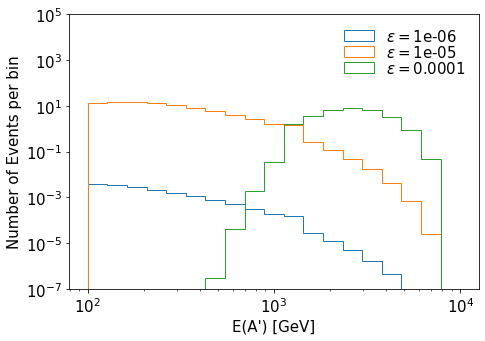

In [12]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
for coup,en,weight in zip(coups,energies,weights):
    if sum(weight)<10**-5 : continue
    ax.hist(en, weights=weight, bins=np.logspace(2,4, 20), histtype='step', label=r"$\epsilon=$"+str(coup)) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(10**-7,10**5) 
    ax.set_xlabel("E(A') [GeV]") 
    ax.set_ylabel("Number of Events per bin") 
    ax.legend(frameon=False, labelspacing=0)
plt.tight_layout()
plt.show()

FORESEE also includes a function `write_events()` which obtains an unweighted sample of LLP decay events and saves them as a HEPMC file. For this function, we need to specify
- the `mass` and `coupling` of the LLP
- the collision `energy`
- the number of events `numberevent` that should be samples (optional, default=10)
- the `filename` of the output file (optional, default=`model/events/<mass>_<coupling>.hepmc`)
- the z-position (in meter) of the beginning of the decay volume (optional, default=0)
- a random `seed` (optional, default=None)

At the moment, FORESEE only supports 2-body LLP decays. For all other cases, including those where no final state information was specified when initiating the `Model`, the LLP will not be decayed. 

In [13]:
foresee.write_events(filename="model/events/test.hepmc", mass=.1, coupling=1e-5, energy="14", numberevent=3, zfront=0)

/Users/felixkling/Documents/GitHub/FORESEE/src/foresee.py:891: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  channels=np.array(channels).T


Let us have a look at a the output:

In [14]:
f = open("model/events/test.hepmc", 'r')
file_contents = f.read()
print (file_contents)

HepMC::Version 2.06.09
HepMC::IO_GenEvent-START_EVENT_LISTING
E 0 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 30.18870916882534 0.
F 0 0 0 0 0 0 0 0 0
P 1 32 0.0127614448 -0.0356824478 112.9462642323 112.9463148585 0.1 2 0 0 0 0
V -1 54.2336952754 -151.6435663285 3164.3164924445 1343276373272.793 0 2 0
P 2 22 -0.0145581839 -0.0468263164 26.3674159445 26.3674615432 4.768e-07 1 0 0 0 0
P 3 22 0.0273196287 0.0111438685 86.5788482976 86.578853325 2.1325e-06 1 0 0 0 0
E 1 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 30.18870916882534 0.
F 0 0 0 0 0 0 0 0 0
P 1 32 -0.0324012146 -0.019653316 142.1909251629 142.1909653767 0.1 2 0 0 0 0
V -1 -109.3781661133 -66.3445395262 3793.653318664 1609633850977.0125 0 2 0
P 2 22 -0.0638114221 -0.0285535241 113.7378907601 113.7379122446 1.3487e-06 1 0 0 0 0
P 3 22 0.0314102075 0.0089002081 28.4530344086 28.453053138 4.768e-07 1 0 0 0 0
E 2 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 30.18870916882534 0.
F 0 0 0 0 0 0 0 0 0
P 1 32 -0.2786641463 0.3211537275 225.35703

## 5. Parameter Scan

In the following, we will get the LLP sensitivity reach for different detector configuraions. As an example, we show the FASER2 and FASER reach for ALPs. We just need to loop over different masses and use the previously introduced funtion `get_events`. The results will be written into a `.npy` file that we can store and plot later.

Note that ALPs are primarilly produced at the TAN, which is located at z=140m. Therefore we adjust the `distance` $L \to L-L_{TAN}$ and $R \to R \times (L-L_{TAN}) / L$ to account for the ALP production at z=140m. 

- the nominal/default FASER2 setup

In [15]:
#specify setup
luminosity, distance = 3000 , 480-140
setup, selection, channels, length = "default", "np.sqrt(x.x**2 + x.y**2)< 1*340./480.", None, 10
foresee.set_detector(length=length, selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach 
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ , _ = foresee.get_events(mass=mass, energy=energy, couplings = np.logspace(-9,0,91))
    list_nevents.append(nevents)  
        
#save results
np.save("model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

/Users/felixkling/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


- FASER

In [16]:
#specify setup
luminosity, distance = 150 , 480-140
setup, selection, channels, length = "FASER", "np.sqrt(x.x**2 + x.y**2)< .1*340./480.", None, 3.5
foresee.set_detector(length=length, selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach 
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ , _ = foresee.get_events(mass=mass, energy=energy, couplings = np.logspace(-9,0,91))
    list_nevents.append(nevents)  
    
#save results
np.save("model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

## 6. Plot the Results

Now let's plot the results. We first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [17]:
setups = [ 
    ["14TeV_FASER.npy",    "FASER "        , "firebrick"  ,  "solid"  , 0., 3],
    ["14TeV_default.npy",  "FASER 2"       , "red"        ,  "solid"  , 0., 3],
]

Then we specify all the existing bounds (filename in model/bounds directory, label, label position x, label position y, label rotation). Constraints from E137, E141, CHARM, LEP, SN1987, NuCal from [1901.09966](https://arxiv.org/pdf/1901.09966.pdf), NA64 from [2005.02710](https://arxiv.org/pdf/2005.02710.pdf), PrimEx from [1903.03586](https://arxiv.org/pdf/1903.03586.pdf) and Belle2 from [2007.13071](https://arxiv.org/abs/2007.13071).

In [18]:
bounds = [ 
    ["bounds_Belle2.txt", "Belle2"  , 0.210, 1.5*10**-3, 0 ],
    ["bounds_PrimEx.txt", "PrimEx"  , 0.126, 1.2*10**-3, 90 ],
    ["bounds_LEP.txt"   , "LEP"     , 0.080, 6.0*10**-3, 0  ],
    ["bounds_SN1987.txt", "SN1987"  , 0.0105,6.0*10**-7, 0 ],
    ["bounds_E137.txt"  , "E137"    , 0.250, 6.0*10**-7, 0 ],
    ["bounds_NuCal.txt" , "NuCal"   , 0.080, 5.0*10**-6, -15 ],
    ["bounds_Charm.txt" , "CHARM"   , 0.041, 3.0*10**-5, -45 ],
    ["bounds_NA64.txt"  , "NA64"    , 0.035, 2.6*10**-4, 0 ],
    ["bounds_E141.txt"  , "E141"    , 0.017, 1.7*10**-3, 0 ],
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [19]:
projections = [
    ["limits_SHiP.txt",         "forestgreen","SHiP"                 , 0.700, 8.00*10**-7, -45  ],
    ["limits_SeaQuest.txt",     "lime"       ,"SeaQuest"             , 0.380, 7.20*10**-7, -45  ],
    ["limits_NA64.txt",         "lime"       ,"NA64"                 , 0.100, 3.20*10**-4, -45  ],
    ["limits_NA62.txt",         "limegreen"  ,"NA62"                 , 0.152, 1.40*10**-5, -45  ],
    ["limits_BelleII_inv.txt",  "blue"       ,r"Belle2 (1$\gamma$)"  , 0.065, 1.50*10**-5, -45  ],
    ["limits_BelleII_3a.txt",   "blue"       ,r"Belle2 (3$\gamma$)"  , 0.400, 3.00*10**-5, 0  ],
]

Finally, we can plot everything using `foresee.plot_reach()`. It returns a matplotlib instance, to which we can add further lines and which we can show or save. Below, we add the dark matter relict target line for a specific benchmark.

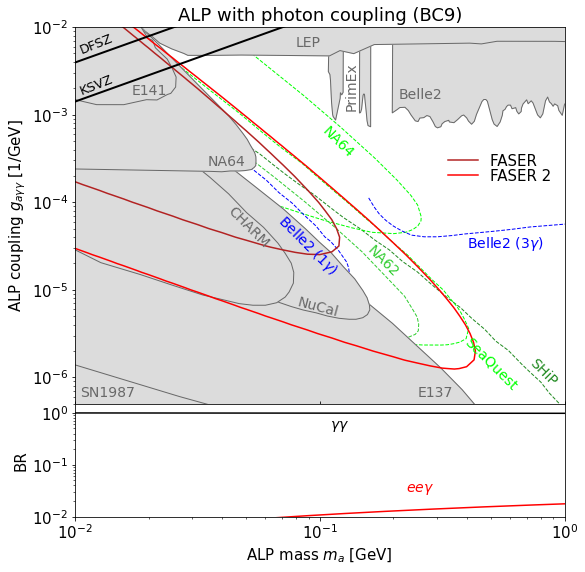

In [20]:
plot, ax, ax2 = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=projections,
    title="ALP with photon coupling (BC9)", 
    xlims=[0.01,1], 
    ylims=[0.5*10**-6,10**-2],
    xlabel=r"ALP mass $m_{a}$ [GeV]", 
    ylabel=r"ALP coupling $g_{a\gamma\gamma}$ [1/GeV]",
    legendloc=(1.00,0.70),
    branchings=branchings,
    figsize=(8,8),
)

# QCD Axion Target Lines
DFSZ = np.array([[0.01, 0.001408], [0.7015, 0.1]])
ax.plot(DFSZ.T[0], DFSZ.T[1], color="k", lw=2)        
ax.text(0.0103, 0.0050, "DFSZ",fontsize=13, color="k",rotation=22)
KSVZ = np.array([[0.01, 0.003939], [0.25413, 0.1]])
ax.plot(KSVZ.T[0], KSVZ.T[1], color="k", lw=2)  
ax.text(0.0103, 0.0017, "KSVZ",fontsize=13, color="k",rotation=22)

plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
plot.savefig("/Users/felixkling/Downloads/Figure.pdf")
plot.show()